<a href="https://colab.research.google.com/github/GiX7000/computer-vision-on-CIFAR-10-from-basics-to-transformers/blob/main/4_numpy_two_layer_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fully-Connected Neural Nets
  

## Intro

In this notebook, we will implement fully-connected networks using a modular approach.

For each layer we will implement a `forward` and a `backward` function.

The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

## Set up code

In [ ]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# This prints the current working directory.
import os
print('Current working directory: ', os.getcwd())

Current working directory:  /content


In [ ]:
# Using Linux commands like `pwd`, `cd` and `ls`, we ensure the project's path.
!ls /content/drive/MyDrive

arrays	cifar-10-batches-py  EuroSAT  lab_0_2024_2025  lab_1_2024_2025	lab_2_2024_2025


In [ ]:
# Location path to `FOLDERPATH` variable.
FOLDERPATH = '/content/drive/MyDrive'
assert FOLDERPATH is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that the Python interpreter of the Colab VM can load python files from within it.
import sys
sys.path.insert(1, FOLDERPATH)

In [ ]:
# Having the dataset, let's change to exercise directory.
%cd {FOLDERPATH}

/content/drive/MyDrive/labs/lab_2_2024_2025


In [ ]:
# As usual, a bit of setup.
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from engine.classifiers.two_layer_net import *
from engine.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from engine.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# For auto-reloading external modules, see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython.
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

## CIFAR-10 Data Loading and Pre-processing

Let's load the CIFAR-10 dataset.

In [ ]:
from engine.data_utils import load_CIFAR10

# Load the raw CIFAR-10 data.
cifar10_dir = '/content/drive/MyDrive/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue).
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Load .npy files

Load dataset from ``.npy`` files! This way is really faster!

In [ ]:
# Specify adrs dir, so that arrays dir is automatically retrieved and arrays can be loaded from it.
labs_dir = '/content/drive/MyDrive'
arrays_dir = os.path.join(labs_dir, 'arrays')

# Load arrays if needed. Uncomment to use!
X_train = np.load(os.path.join(arrays_dir, 'full_X_train.npy'))
y_train = np.load(os.path.join(arrays_dir, 'full_y_train.npy'))
X_test = np.load(os.path.join(arrays_dir, 'full_X_test.npy'))
y_test = np.load(os.path.join(arrays_dir, 'full_y_test.npy'))

# Num of samples for training and test.
num_training = X_train.shape[0]
num_test = X_test.shape[0]

## Split data

In [ ]:
# Split the data into train, val, and test sets. In addition we will create a small development set as a subset of the training data. We can use this for development so our code runs faster.
num_training = 45000
num_validation = 5000
num_test = 10000
num_dev = 500

# Our validation set will be num_validation points from the original training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (45000, 32, 32, 3)
Train labels shape:  (45000,)
Validation data shape:  (5000, 32, 32, 3)
Validation labels shape:  (5000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


## Fully Connected / Linear layer / Affine layer: forward

In the file `engine/layers.py`, we implement the `affine_forward()` function. We test our implementation by running the following:

In [ ]:
# Test the affine_forward function.
from engine.layers import *

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours (the error should be around e-9 or less).
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.769849468192957e-10


## Fully Connected / Linear layer / Affine layer: backward

In the same folder, we also implement the `affine_backward()` function and test our implementation using numeric gradient checking.

For the **weight** and **input** gradient, have a look at [this](http://cs231n.stanford.edu/handouts/linear-backprop.pdf) and [this](https://web.eecs.umich.edu/~justincj/teaching/eecs442/notes/linear-backprop.html).

For the **bias** gradient, have a look at [this](https://datascience.stackexchange.com/questions/20139/gradients-for-bias-terms-in-backpropagation) and [this](https://eli.thegreenplace.net/2018/backpropagation-through-a-fully-connected-layer/).

In [ ]:
# Test the affine_backward function.
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around e-10 or less.
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.399100368651805e-11
dw error:  9.904211865398145e-11
db error:  2.4122867568119087e-11


## ReLU activation: forward

Now, let's implement the forward pass for the ReLU activation function in the `relu_forward()` function in `engine/layers.py` and test our implementation using the following:

In [ ]:
# Test the relu_forward function.

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours (the error should be on the order of e-8).
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.999999798022158e-08


## ReLU activation: backward

We also implement the backward pass for the ReLU activation function in the `relu_backward()` function in `engine/layers.py` and test our implementation using numeric gradient checking.

For the **ReLU** gradient, have a look at [this](https://datascience.stackexchange.com/questions/19272/deep-neural-network-backpropogation-with-relu).

In [ ]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be on the order of e-12.
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.2756349136310288e-12


Sigmoid suffers from vanishing gradients problem, while ReLU produces zero gradients for negative inputs of x.

**Sigmoid**: $$ \sigma(x) = \frac{1}{1 + e^{-x}} $$


For large positive inputs of x, sigmoid goes close to 1 and, respectively, for large negative inputs of x, sigmoid goes very close to 0. In these two points, the gradient(slope of function) approaches 0. So, the vanishing gradient problem happens, and, this is one reason why we don't use sigmoid as an activation function in hidden layers(it is only used in the final output layer of NNs as an activation in binary tasks).



**ReLU**: $$ \text{ReLU}(x) = \max(0, x) $$

Here, negative inputs of x produce zero gradients. So, during training, if any activation produces a negative output, then, this neuron will produce zero gradients and there will be no contribution to updates from this neuron(also known as "dying ReLU" problem).


**Leaky ReLU**: $$ \text{Leaky ReLU}(x) = \begin{cases}
x & \text{if } x > 0 \\
\alpha x & \text{if } x \leq 0
\end{cases} $$

The "dying ReLU" problem drove scientists to design LeakyReLU, which ensures that for even negative inputs of x, gradients can take very small, non-zero, values.

We  can clearly observe where and when gradients can be 0 in the below image.


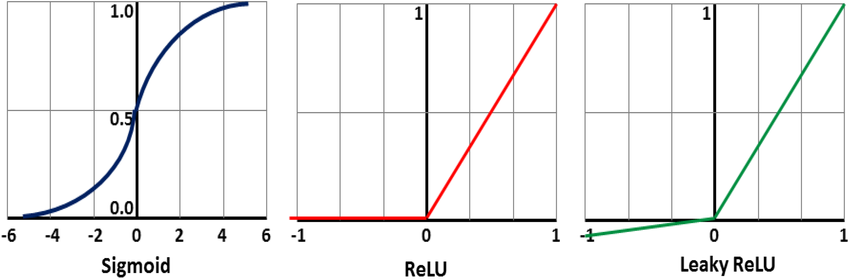

## "Sandwich" layers / Stacking layers

There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define convenience layers in the file `engine/layer_utils.py`.

Take a look at the `affine_relu_forward()` and `affine_relu_backward()` functions, and run the following to numerically gradient check the backward pass:

In [ ]:
from engine.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

# Relative error should be around e-10 or less.
print('Testing affine_relu_forward and affine_relu_backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward and affine_relu_backward:
dx error:  2.299579177309368e-11
dw error:  8.162011105764925e-11
db error:  7.826724021458994e-12


## Loss: Softmax and SVM

Now, we implement the loss and gradient for softmax and SVM in the `softmax_loss()` and `svm_loss()` function in `engine/layers.py`. We test if our implementations are correct by running the following:

In [ ]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9.
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8.
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.999602749096233
dx error:  1.4021566006651672e-09

Testing softmax_loss:
loss:  2.3025458445007376
dx error:  8.234144091578429e-09


## Two-layer network

Next, we implement the `TwoLayerNet` class of the file `engine/classifiers/two_layer_net.py` and test our implementation with the below cell.

In [ ]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-7 or less.
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.83e-08
W2 relative error: 3.20e-10
b1 relative error: 9.83e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 2.53e-07
W2 relative error: 2.85e-08
b1 relative error: 1.56e-08
b2 relative error: 9.09e-10


## Solver

Almost all the job is done in the file `engine/solver.py`. Navigate through it!

Next, we have to implement the `sgd()` function in `engine/optim.py` and then we use a `Solver` instance to train a `TwoLayerNet`.

In [ ]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
model = TwoLayerNet(input_size, hidden_size, num_classes)
solver = None
data = {"X_train":X_train, "y_train":y_train, "X_val":X_val, \
        "y_val":y_val, "X_test":X_test, "y_test":y_test}

# Use a Solver instance (default values) to train a TwoLayerNet.
solver = Solver(model, data, update_rule='sgd',
                    optim_config={
                      'learning_rate': 1e-3,
                    },
                    lr_decay=0.95,
                    num_epochs=10, batch_size=100,
                    print_every=100)
solver.train()

(Iteration 1 / 4500) loss: 2.310409
(Epoch 0 / 10) train acc: 0.102000; val_acc: 0.112800
(Iteration 101 / 4500) loss: 2.202703
(Iteration 201 / 4500) loss: 2.213021
(Iteration 301 / 4500) loss: 2.284839
(Iteration 401 / 4500) loss: 2.167954
(Epoch 1 / 10) train acc: 0.159000; val_acc: 0.157000
(Iteration 501 / 4500) loss: 2.220209
(Iteration 601 / 4500) loss: 2.246454
(Iteration 701 / 4500) loss: 2.120233
(Iteration 801 / 4500) loss: 2.185510
(Epoch 2 / 10) train acc: 0.144000; val_acc: 0.142000
(Iteration 901 / 4500) loss: 2.287953
(Iteration 1001 / 4500) loss: 2.021410
(Iteration 1101 / 4500) loss: 2.249686
(Iteration 1201 / 4500) loss: 1.982681
(Iteration 1301 / 4500) loss: 2.168061
(Epoch 3 / 10) train acc: 0.190000; val_acc: 0.189600
(Iteration 1401 / 4500) loss: 1.985782
(Iteration 1501 / 4500) loss: 2.053765
(Iteration 1601 / 4500) loss: 1.960894
(Iteration 1701 / 4500) loss: 1.989837
(Epoch 4 / 10) train acc: 0.257000; val_acc: 0.265000
(Iteration 1801 / 4500) loss: 2.000410
(

## Debug the training

With the default parameters we provided above, we get a validation accuracy of about `35%` on the validation set. This isn't so good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

### Visualize loss and accuracy

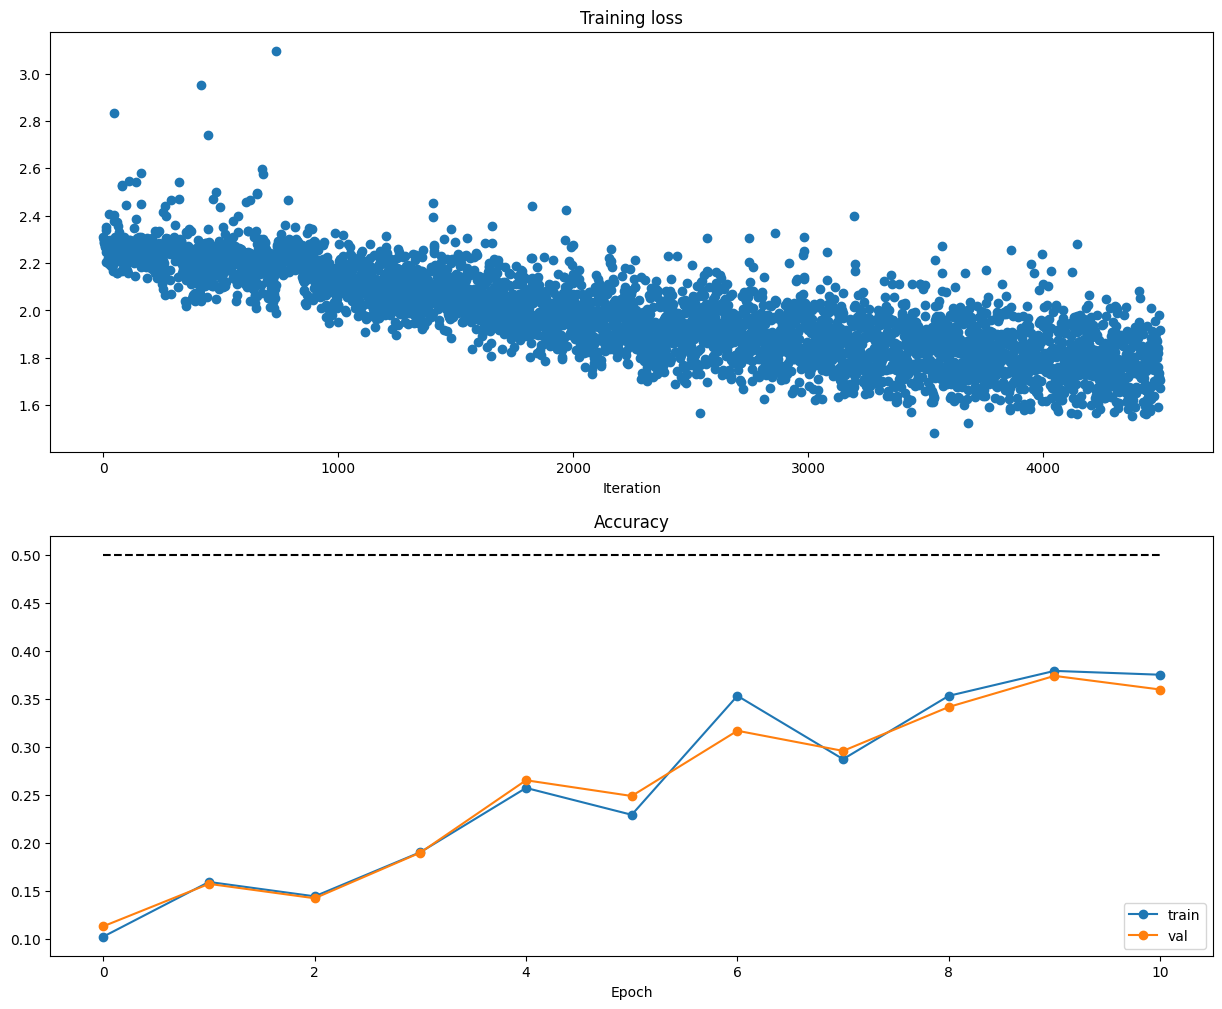

In [ ]:
# Visualize training loss and train / val accuracy.

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

### Visualize weights

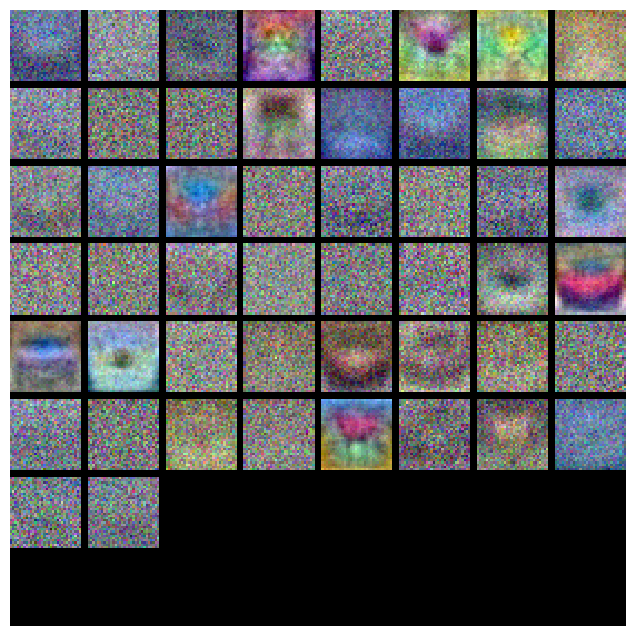

In [ ]:
from engine.vis_utils import visualize_grid

# Visualize the weights of the network.

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(model)

## Tune your hyperparameters


**What's wrong?** Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks. Below, we experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. We also consider tuning the learning rate decay, but also getting good performance using the default value.

Our goal in this experiment is to achieve the highest possible validation accuracy on CIFAR-10 using a fully-connected neural network, with at least a `46%` as a strong reference target.

To accomplish this, we implement a hyperparameter tuning process, trying different configurations of learning rates, hidden layer sizes, and other strategies you think may improve performance.

Here are some ideas to have in mind and always explore:

•	**Hyperparameter Tuning**: Experiment with various learning rates, hidden layer sizes, and batch sizes to find the optimal configuration.

•	**Dimensionality Reduction**: Consider using PCA to reduce the input dimensionality, which can help improve performance by simplifying the feature space.

•	**Regularization Techniques**: Implement dropout or L2 regularization to prevent overfitting.

In [ ]:
# Tune hyperparameters using the validation set.
from tqdm import tqdm
import random

# Set some hyperparams.
best_model = None # Store our best trained model in best_model.
hidden = [100, 200]
learning_rates = [1e-2, 1e-3, 1e-4]
reg = [1e-4, 1e-5, 1e-6]
epochs = [10, 20]
batch_sizes = [100, 200]

# Useful initializations.
results = {}
results_list = []
best_val_acc = 0.0

# Create a list of all hyperparameter combinations.
import itertools
hyperparams = list(itertools.product(hidden, learning_rates, reg, epochs, batch_sizes))

# The above list produces 72 combinations. let's take randomly 10 of them and see if we can take val accuray > 40%.
combinations = random.sample(hyperparams, 10)

# Iterate over hyperparams combinations and train models.
print("Start training ... ")
for h, lr, r, e, b in tqdm(combinations, leave=True):
 print(f"\nTraining with hidden_dim={h}, lr={lr}, reg={r}, epochs={e}, batch_size={b}")

 # Create model and solver instances.
 model = TwoLayerNet(input_dim=input_size, hidden_dim=h, reg=r, num_classes=num_classes)
 solver = Solver(model, data, optim_config={'learning_rate': lr},
                 update_rule='sgd', num_epochs=e, batch_size=b, verbose=False)
 # Start training solver instance.
 solver.train()

 # Save the results in a dictionary.
 results = {
     "hidden": h,
     "lr": lr,
     "reg": r,
     "batch": b,
     "epochs": e,
     "Val acc": solver.check_accuracy(data['X_val'], data['y_val'])
        }

 results_list.append(results)

 # Store best val accuracy and best model.
 if solver.best_val_acc > best_val_acc:
  best_val_acc = solver.best_val_acc
  best_model = solver.model # Save current best solver's model.

 # Print current model's(combination's) best validation accuracy.
 print(f"\nValidation accuracy: ", solver.best_val_acc)

# Print best validation acacuracy of all combinations(models).
print(f"\nBest validation accuracy achieved: {best_val_acc}")

# Create a pandas dataframe and print the results in a table.
import pandas as pd
results_df = pd.DataFrame(results_list)
print("\n\n", results_df)

Start training ... 


  0%|          | 0/10 [00:00<?, ?it/s]


Training with hidden_dim=200, lr=0.01, reg=0.0001, epochs=20, batch_size=200


 10%|█         | 1/10 [03:16<29:27, 196.38s/it]


Validation accuracy:  0.1064

Training with hidden_dim=100, lr=0.001, reg=1e-06, epochs=20, batch_size=200


 20%|██        | 2/10 [05:14<20:00, 150.08s/it]


Validation accuracy:  0.3568

Training with hidden_dim=200, lr=0.0001, reg=1e-06, epochs=20, batch_size=200


 30%|███       | 3/10 [08:31<20:01, 171.59s/it]


Validation accuracy:  0.464

Training with hidden_dim=200, lr=0.01, reg=0.0001, epochs=10, batch_size=200


 40%|████      | 4/10 [10:13<14:25, 144.27s/it]


Validation accuracy:  0.1058

Training with hidden_dim=200, lr=0.01, reg=1e-06, epochs=20, batch_size=100


 50%|█████     | 5/10 [14:05<14:38, 175.68s/it]


Validation accuracy:  0.1038

Training with hidden_dim=200, lr=0.01, reg=1e-06, epochs=10, batch_size=100


 60%|██████    | 6/10 [16:04<10:26, 156.75s/it]


Validation accuracy:  0.1058

Training with hidden_dim=200, lr=0.01, reg=1e-05, epochs=10, batch_size=100


 70%|███████   | 7/10 [18:01<07:11, 143.71s/it]


Validation accuracy:  0.0978

Training with hidden_dim=100, lr=0.01, reg=1e-06, epochs=20, batch_size=200


 80%|████████  | 8/10 [19:56<04:28, 134.49s/it]


Validation accuracy:  0.1058

Training with hidden_dim=100, lr=0.001, reg=0.0001, epochs=10, batch_size=100


 90%|█████████ | 9/10 [21:02<01:52, 112.94s/it]


Validation accuracy:  0.199

Training with hidden_dim=100, lr=0.01, reg=0.0001, epochs=20, batch_size=100


100%|██████████| 10/10 [23:12<00:00, 139.28s/it]


Validation accuracy:  0.1058

Best validation accuracy achieved: 0.464


    hidden      lr       reg  batch  epochs  Val acc
0     200  0.0100  0.000100    200      20   0.1064
1     100  0.0010  0.000001    200      20   0.3568
2     200  0.0001  0.000001    200      20   0.4640
3     200  0.0100  0.000100    200      10   0.1058
4     200  0.0100  0.000001    100      20   0.1038
5     200  0.0100  0.000001    100      10   0.1058
6     200  0.0100  0.000010    100      10   0.0978
7     100  0.0100  0.000001    200      20   0.1058
8     100  0.0010  0.000100    100      10   0.1990
9     100  0.0100  0.000100    100      20   0.1058


## Test our model!

We run our best model on the validation and test sets (expected accuracy above 45% in both validation and test sets).

In [ ]:
print(best_model)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

Validation set accuracy:  0.464


In [ ]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Test set accuracy:  0.4575


## Try alternative Optimizers

Having optimized our model using vanilla `SGD`, let's explore the effects of different optimization techniques.

For this final experiment, we will implement `sgd_momentum()`, `rmsprop()`, and `adam()` in `engine/optim.py` to enable training with `SGD with Momentum`, `RMSProp`, and `Adam` optimizers.

After implementing these functions, we use a Solver instance to train a TwoLayerNet with each of these alternative optimizers. We compare the performance of each optimizer in terms of validation accuracy and training speed.

Start training...

Training with optimizer=sgd
Validation accuracy:  0.4664
Training time: 200.63 seconds

Training with optimizer=sgd_momentum
Validation accuracy:  0.4754
Training time: 210.97 seconds

Training with optimizer=rmsprop
Validation accuracy:  0.4472
Training time: 221.67 seconds

Training with optimizer=adam
Validation accuracy:  0.4838
Training time: 254.09 seconds

Best validation accuracy achieved: 0.4838, with optimizer: adam


    hidden      lr       reg  batch  epochs     optimizer  Val acc  \
0     200  0.0001  0.000001    200      20           sgd   0.4664   
1     200  0.0001  0.000001    200      20  sgd_momentum   0.4754   
2     200  0.0001  0.000001    200      20       rmsprop   0.4472   
3     200  0.0001  0.000001    200      20          adam   0.4838   

   train time (s)  
0      200.633367  
1      210.970621  
2      221.673197  
3      254.089876  


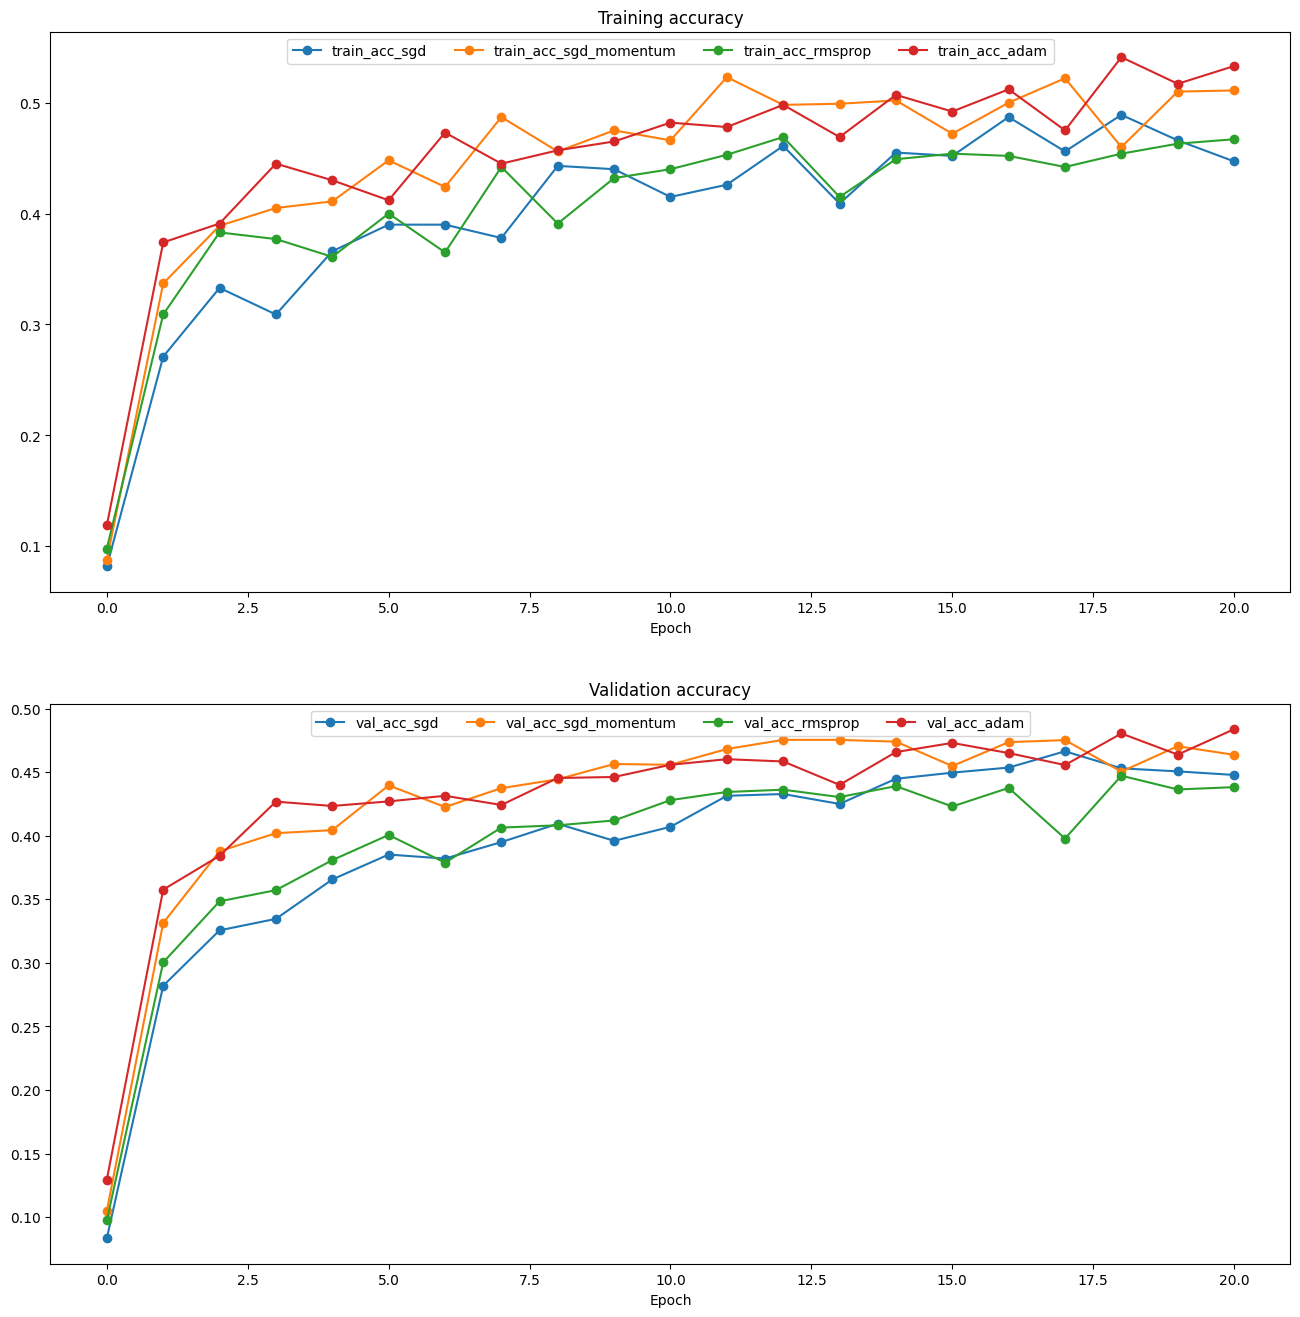

In [ ]:
# Use a Solver instance to train a TwoLayerNet with SGD with momentum, RMSProp, and Adam optimizers.
import time
best_model = None

# Get the above best combination of hyperparams.
hidden = 200
learning_rate = 1e-4
reg = 1e-6
epochs = 20
batch_size = 200

# Useful initializations.
results = {}
results_list = []
best_val_acc = 0.0
solvers = {}

# List of optimizers to compare.
optimizers = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']

# Iterate over optimizers.
print("Start training...")
for optimizer in optimizers:
  print(f"\nTraining with optimizer={optimizer}")
  # Model instance.
  model = TwoLayerNet(input_dim=input_size, hidden_dim=hidden, reg=reg, num_classes=num_classes)

  # Solver instance with the current optimizer.
  solver = Solver(model, data, optim_config={'learning_rate': learning_rate},
                  update_rule=optimizer, num_epochs=epochs, batch_size=batch_size, verbose=False)

  # Store the current solver.
  solvers[optimizer] = solver

  # Start the timer.
  start_time = time.time()

  # Train the model.
  solver.train()

  # Stop the timer.
  end_time = time.time()

  # Calculate the training time.
  training_time = end_time - start_time

  # Save the results in a dictionary.
  results = {
      "hidden": hidden,
      "lr": learning_rate,
      "reg": reg,
      "batch": batch_size,
      "epochs": epochs,
      "optimizer": optimizer,
      "Val acc": solver.check_accuracy(data['X_val'], data['y_val']),
      "train time (s)": training_time
       }

  # Append the results for this combination to the list.
  results_list.append(results)

  # Store best val accuracy and best model.
  if solver.best_val_acc > best_val_acc:
    best_val_acc = solver.best_val_acc
    best_model = solver.model # Best solver's model until now.
    best_optimizer = optimizer

  # Print current's optimizers model best validation accuracy.
  print(f"Validation accuracy: ", solver.best_val_acc)
  # Print training time.
  print(f"Training time: {training_time:.2f} seconds")

# Print best validation acacuracy of all combinations.
print(f"\nBest validation accuracy achieved: {best_val_acc}, with optimizer: {best_optimizer}")

# Convert the results list into a pandas DataFrame and display it.
results_df = pd.DataFrame(results_list)
print("\n\n", results_df)

# Create some plots.
plt.subplot(2, 1, 1)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for optimizer, solver in solvers.items():

  plt.subplot(2, 1, 1)
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % optimizer)

  plt.subplot(2, 1, 2)
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % optimizer)

# Adjust legend, size and display the plot.
for i in [1, 2]:
  plt.subplot(2, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(16, 16)
plt.show()

Best validation accuracy wiith Adam optimizer with also the longest training time. So, if we want only the model with the best accuracy, we choose Adam, for this task. If we are interested for both accuracy and training time, SGD_momentum is the best alternative, while SGD is the best if speed is our only concern. Another trade-off here between accuracy and time. Time, in its turn, is much dependent on computational resources. And, due to computational limitations of Colab, this notebook ran exclusively on CPU. So, time would be different if GPU was available.

In [ ]:
# A quick test on validation and tests sets.
print(f"Best model with {best_optimizer} optimizer!")
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())

y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Best model with adam optimizer!
Validation set accuracy:  0.4838
Test set accuracy:  0.4772


If the testing accuracy is much lower than the training accuracy, it means that the model overfits. It can't make correct predictions on new, unseen data. So, by training the model on more data, it may help it to generalize better. In addition, by penalizing the current weights by adding regularization can also help reducing this gap between training and testing accuracy. Finally, if we add more hidden layers, we make the model more complex and, in this way, we lead the model to overfit more.